In [16]:
!pip install pycocotools


In [11]:
import torchvision 
import os 
from transformers import DetrImageProcessor, DetrForObjectDetection, DetrConfig


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = '/kaggle/input/bc-coco/coco_1k/annotations/instances_train2017.json' if train else '/kaggle/input/bc-coco/coco_1k/annotations/instances_val2017.json'
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)
#         image_id = self.ids[idx] 
#         normalized_boxes = labels['boxes']
        image_width, image_height = labels['orig_size']
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() 
        target = encoding["labels"][0] 

        return pixel_values, target


    
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
# config = DetrConfig.from_pretrained(
#     "facebook/detr-resnet-50-panoptic",
#     num_labels=2,
#     class_cost=1
# )

train_dataset = CocoDetection(img_folder='/kaggle/input/bc-coco/coco_1k/train2017/', processor=processor,train=True)
val_dataset = CocoDetection(img_folder='/kaggle/input/bc-coco/coco_1k/val2017/', processor=processor, train=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [12]:
train_dataset[148]

{'size': tensor([1333,  447]), 'image_id': tensor([148]), 'class_labels': tensor([0]), 'boxes': tensor([[0.9570, 0.4085, 0.0817, 0.0664]]), 'area': tensor([3232.2712]), 'iscrowd': tensor([0]), 'orig_size': tensor([1050,  352])}


(tensor([[[0.5193, 0.5364, 0.5364,  ..., 2.1804, 2.2489, 2.2489],
          [0.4851, 0.4851, 0.4851,  ..., 1.6495, 2.1975, 2.2489],
          [0.4337, 0.4337, 0.4337,  ..., 1.0331, 1.7694, 2.2489],
          ...,
          [0.6392, 0.6392, 0.6392,  ..., 2.2489, 2.2489, 2.2489],
          [0.7077, 0.7248, 0.7248,  ..., 2.2489, 2.2489, 2.2489],
          [0.8276, 0.8104, 0.8104,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[0.6604, 0.6779, 0.6779,  ..., 2.3585, 2.4286, 2.4286],
          [0.6254, 0.6254, 0.6254,  ..., 1.8158, 2.3761, 2.4286],
          [0.5728, 0.5728, 0.5728,  ..., 1.1856, 1.9384, 2.4286],
          ...,
          [0.7829, 0.7829, 0.7829,  ..., 2.4286, 2.4286, 2.4286],
          [0.8529, 0.8704, 0.8704,  ..., 2.4286, 2.4286, 2.4286],
          [0.9755, 0.9580, 0.9580,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[0.8797, 0.8971, 0.8971,  ..., 2.5703, 2.6400, 2.6400],
          [0.8448, 0.8448, 0.8448,  ..., 2.0300, 2.5877, 2.6400],
          [0.7925, 0.7925, 0.7925,  ...,

In [ ]:
from torch.utils.data import DataLoader

In [17]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 2240
Number of validation examples: 218


Image n°148
{'id': 68, 'image_id': 148, 'category_id': 0, 'iscrowd': 0, 'area': 2004.9432408603109, 'bbox': [322.5, 394.0, 28.745755517826808, 69.74745331069613], 'segmentation': None}
(322.5, 394.0, 28.745755517826808, 69.74745331069613)


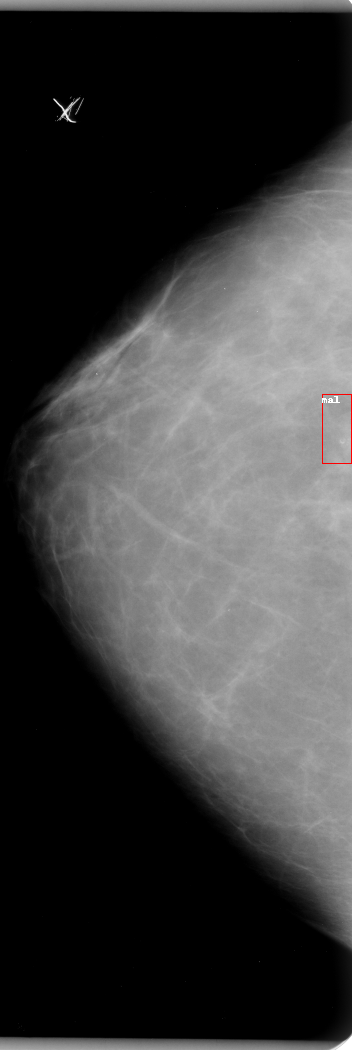

In [15]:
import numpy as np
import os
from PIL import Image, ImageDraw

image_ids = train_dataset.coco.getImgIds()

image_id = image_ids[148]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/kaggle/input/bc-coco/coco_1k/train2017', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  print(annotation)
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  print(tuple(box))
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')
image

In [ ]:
def collate_fn(batch):
      pixel_values = [item[0] for item in batch]
      encoding = processor.pad(pixel_values, return_tensors="pt")
      labels = [item[1] for item in batch]
      batch = {}
      batch['pixel_values'] = encoding['pixel_values']
      batch['pixel_mask'] = encoding['pixel_mask']
      batch['labels'] = labels
     # print(batch)
      return batch
        
        
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

In [ ]:
print(batch)
print(batch['pixel_values'][1].shape)

In [ ]:
categories = train_dataset.coco.cats
print(categories)

id2label = {k: v['name'] for k,v in categories.items()}

In [ ]:
from transformers import DetrForObjectDetection



#model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
#model.config=config

model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True,
                                                             num_queries = 25)
#                                                              encoder_attention_heads =4,
#                                                              decoder_attention_heads=4,
#                                                              decoder_ffn_dim=1024,
#                                                              encoder_ffn_dim=1024)

In [ ]:
out=model(**batch)

In [ ]:
print(out.loss)

In [ ]:
import torch
import torch.optim as optim
loss_dict = out.loss_dict
total_loss=sum(loss.item() for loss in loss_dict.values())
total_loss_tensor = torch.tensor(total_loss, requires_grad=True)
total_loss_tensor.backward()

In [ ]:
def train_detr_model(model, optimizer, train_data, val_data, num_epochs):
    print("training the model")
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        avg_train_loss = 0.0
        num_batches = 0.0
        for batch in train_data:
            pixel_values=batch['pixel_values']
            pixel_mask = batch['pixel_mask']
            labels=batch['labels']
            for label_dict in labels:
                for key, value in label_dict.items():
                    label_dict[key] = value.to(device)
            optimizer.zero_grad()
            outputs = model(pixel_values=pixel_values.to(device),pixel_mask=pixel_mask.to(device),labels=labels)
            total_loss = outputs.loss 
            total_loss.backward()
            optimizer.step()
            avg_train_loss += total_loss.item()
            num_batches += 1
        avg_train_loss /= num_batches
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}')

In [ ]:
labels=batch['labels']
#            # for key,val in labels
# print(labels)
for label in labels:
    print(label)

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_detr_model(model.to(device), optimizer, train_data=train_dataloader, val_data=val_dataloader, num_epochs=50)